In [1]:
# general imports usually needed
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd

In [2]:
# libraries more specific to this lecture notebook
import os.path
import sys
sys.path.append('../../src')
from ml_python_class.config import DATA_DIR

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# notebook wide settings to make plots more readable and visually better to understand
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', titlesize=18)
mpl.rcParams['figure.figsize'] = (10.0, 8.0) # default figure size if not specified in plot

# 3. (Chapter 3) Classification

In [4]:
# reload the MNIST data set for the second half of this lecture/notebook
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

# extract the full data and target labels
X, y = mnist['data'], mnist['target']

# convertes to an integer using 8 bits, but we only need 4 bits here
y = y.astype(np.uint8) 

# perform our train/test split of the data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


## 3.4 Multiclass Classification

Binary classification is common, many problems have a label of true/false, yes/no, ham/spam, etc.
But when the categorical output you want to predict is non-binary, we need to train a 
multiclass classifier (also sometimes called a multinomial classifier).

Some algorithms (random forest, naive bayes classifiers) can handle multiple classes directly.
Other algorithms (such as SVM or logistic classifiers) are strictly binary classifiers. However, 
you can always train multiple binary classifiers, one for each class/not-class (like 5s/not-5s) and 
then combine the results of the multiple binary classifiers to form a multiclass classifier.  

For example, one strategy using MNIST as an example, would be to train a binary classifier for 
each digit.  If the classifier provides decision score, you can select the one whose decision
score was highest as the multiclass output.  This is called a one-versus-all (OvA) stragey.

More complicated, you can build a classifier for every pair, e.g. 0s vs. 1s, 0s vs. 2s...
8s vs. 9s.  This is called one-versus-one (OvO) strategy.  If there are $N$ classes you need to train
$N \times (N -1) /2$ classifiers.  For MNIST this means a total of 45 classifiers are needed.  When 
you want to classify an image, you run it through all 45 classifiers, and see which classifier won
the most duels. This becomes your multiclass classification output.

The first strategy OvA scales linearly in size $\mathcal{O}(N)$ of the number of classes, while OvA is
$\mathcal{O}(N^2)$, which can be a factor.  But OvO only uses a small portion of the dataset (when
N is large) for each paired classifier.  When the algorithm scales poorly with the size of the 
training set, OvO might be preferred (such as SVMs).  But for most multiclass classification,
OvA is preferred.


`sklearn` mostly will do the details for you to build a multiclass classifier for those algorithms that 
are strictly binary in nature.  It will detect when you try and use a binary classification
algorithm for a multiclass classification task and automatically set up and train OvA (except 
for SVM classifiers which use OvO).

Lets try training a multiclass classifier on all 10 digit categories using the `SGDClassifier`
again.  SGD is inherently binary, so `sklearn` sets up OvA and trains 10 classifiers for you,
and combines the score/results.

In [5]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [6]:
sample_num = 0
some_digit = X[sample_num]

sgd_clf.predict([some_digit])

array([3], dtype=uint8)

That worked, though it will sometimes get the prediction wrong for the first digit (recall digit 
0 is a 5).  

The above cell trains an `SGDClassifier` on the training set using the full multiclass set of y_train 
labels for supervised training.  Under the hood, `sklearn` actually trained 10 binary classifiers, 
got their decision scores for the image, and selected the class with the highest scores.

We can see the raw decision scores for the 10 classifiers that were created using the 
`decision_function()` method.  Instead of returning a single socre, it returns 10 scores, one per 
each of the 10 classes.

In [7]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

The highest score should correspond to the class we got back from predict.  We can use argmax to 
get the index of the highest score, and convert that to the corresponding class (which is what
`sklearn` is doing to get a final prediction from the 10 classifier score outputs).

In [8]:
np.argmax(some_digit_scores)

3

In [9]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [10]:
sgd_clf.classes_[3]

3

If we need to, we can explictly force OvO instead of OvA.  `sklearn` supports wrapper 
estimators named `OneVsOneClassifier` and `OneVsRestClassifier`.  These take a 
binary classifier as their meta-parameter, and sets up the appropriate multiclass
configuration.

In [11]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)

ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [12]:
# notice as discussed there are 45 individual OvO estimators created for this multiclass classifier
len(ovo_clf.estimators_)

45

Training other multiclass classifires is just as easy.  We can train a `RandomForestClassifier`.
The `RandomForestClassifier` can be used directly for multiclass classification, so `sklearn` 
did not have to run OvA or OvO here.

In [13]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

forest_clf.predict([some_digit])

array([5], dtype=uint8)

We can get the list of probibilities that the classifier assigned to each instance of 
this class:

In [14]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

You can see that the classifier here is fairly confident about its prediciton, it estimates a 90%
probability that the image represents a 5.  It also thinks if might be a 3 with 8% change, and 2 and 9
both have a small estimate of being the correct class as well.

Now of course you want to evaluate these classifiers.  As usual we will use cross validation, 
though the confusion matrix is now going to be a 10x10 matrix when we evaluate.

Lets evaluate the `SGDClassifiers` basic accuracy using `cross_val_score()`.

In [15]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Wheras before a basic score of 90% could be achieved by always guessing not-5, here something 
that always guesses the same thing, or a random guesser, will achieve a score of only 10%.  
So an average accuracy of 85% or so is not too shabby here.  But we can do better (best known 
algorithms achieve over 99.9% cross validation accuracy on MNIST).

We did not scale the inputs before training here, would that make a difference?  The
range of values for the pixel image attributes are:

In [16]:
print("range minimum: ", X_train.min())
print("range maximum: ", X_train.max())

range minimum:  0.0
range maximum:  255.0


The value range from 0 to 255 (not 0 to 1 as I may have said before).  Scaling the inputs 
can get a slight increase for the SGD classifier.

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 3.5 Error Analysis

To improve our multiclass classifiers we might want to start with the confusion matrix again.  This 
could help us begin to analyze the types of errors and mistakes the classifier makes.  For example, 
is any class particularly difficult for the classifier.


In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

The confusion matrix is a lot of numbers, though you can see as you would expect most of the results are
on correct classifications along the main diagonal.  Recall that rows are the true label here (with row 
0 for class 0 starting at the top, down to 9), and columns are the prediction made by the 
classifier. 

When working with more than a binary confusion matrix, it is often good visualize 
the numbers to better find patterns.

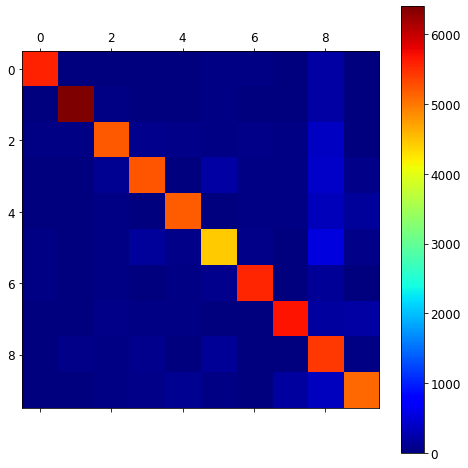

In [19]:
plt.matshow(conf_mx, cmap=plt.cm.jet)
plt.colorbar();

The confusion matrix looks fairly good, the 5's look slightly colder (meaning they are not 
getting classified correctly as much as other digits as we might expect).  

But we really want to focus on the errors and find patterns if any there.  If we divide each 
row by the number of images in that class we can compare error rates instead of absolut number 
of errors.  Lets do that and replot.

In [20]:
# get sum of each row, which is the number of instances of each class
row_sums = conf_mx.sum(axis=1, keepdims=True)

# vectorized division will divide each value by the total values in the class, resulting in
# a number between 0.0 and 1.0.  The diagnol will be the correct classification rate, and the 
# off diagnol elements will be the error rates for a particular combination of digits
norm_conf_mx = conf_mx / row_sums
norm_conf_mx


array([[9.41583657e-01, 0.00000000e+00, 3.71433395e-03, 8.44166807e-04,
        1.35066689e-03, 7.25983454e-03, 6.07800101e-03, 1.01300017e-03,
        3.79875063e-02, 1.68833361e-04],
       [0.00000000e+00, 9.49273213e-01, 5.48798576e-03, 3.55977455e-03,
        5.93295758e-04, 6.52625334e-03, 5.93295758e-04, 1.03826758e-03,
        3.14446752e-02, 1.48323939e-03],
       [4.53172205e-03, 4.53172205e-03, 8.76132931e-01, 1.54414233e-02,
        1.22524337e-02, 4.53172205e-03, 1.12453844e-02, 6.04229607e-03,
        6.34441088e-02, 1.84625713e-03],
       [3.58832164e-03, 2.77279400e-03, 1.90833469e-02, 8.52552602e-01,
        3.26211059e-04, 3.31104224e-02, 4.40384929e-03, 6.52422117e-03,
        6.57315283e-02, 1.19067036e-02],
       [2.05409106e-03, 2.39643958e-03, 7.01814447e-03, 1.54056830e-03,
        8.87024991e-01, 2.05409106e-03, 5.81992468e-03, 4.62170490e-03,
        5.93974666e-02, 2.80725779e-02],
       [4.98063088e-03, 2.76701716e-03, 5.53403431e-03, 3.09905921e-02,
   

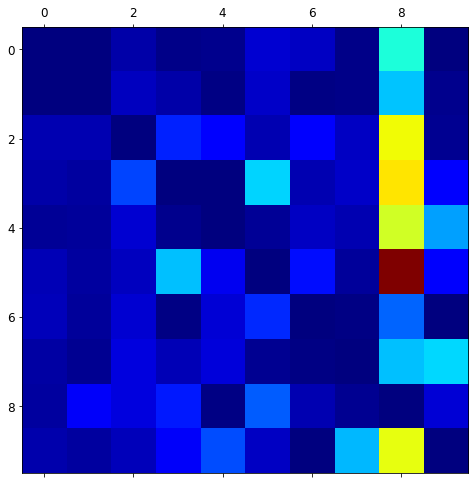

In [21]:
# fill the correct classifications diagnol with 0's, we want to only visualize the errors
np.fill_diagonal(norm_conf_mx, 0)

# show the confusion matrix like before, but now with error rates and correct prediction rates removed
plt.matshow(norm_conf_mx, cmap=plt.cm.jet)

These manipulations help the error pattern stand out much more clearly.  Recall that columns 
are the prediction.  Lots of things are being misclassified as an 8.  However the row for class 8 does
not particularly stand out, meaning that actual 8's in general get properly classified. 

Another not quite so noticable pattern is that 2,5 and 5,2 are relatively hotter.  So 2's and 5's
are being confused, which is certainly understandable.

Notice that the confusion matrix is not necessarily symmetrical.  You might have thought that
2,7 and 7,2 would have the same value.  But actual 2 being misclassified as a 7 can and will have 
a different count from actual 7 being misclassified as 2. 

Analyzing the confusion matrix can often give insights on ways to improve your classifier.  We should 
certainly concentrate on 8's here.

Analyzing individual errors can also provide insights into what is going wrong with a ML
classifier. For example, we might plot examples of 3's and 5s.

This example from the textbook is ding things a bit by hand, but it pulls out examples of 
3s predicted correct, 3's misclassified as 5s, 5's misclassified as 3's and 5's classified
correctly.

In [22]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [23]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

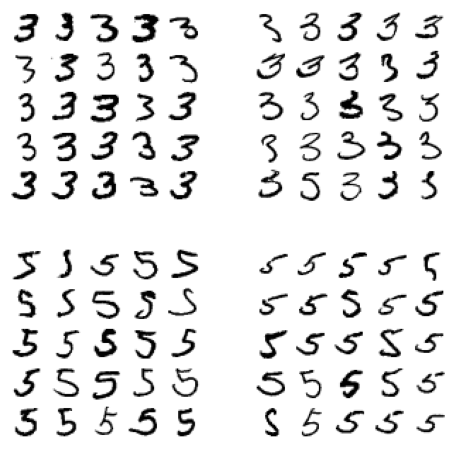

In [24]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

The upper left and lower right are the correct 3 and correct 5 classifications. 

Some of the misclassifications are so bad it would be understandable for humans to 
make the misclassification.  The top row 2nd column of the misclassified 5s and the 
middle value of the misclassified 3's stand out.  Also the bottom row column 2 of the 
misclassified 5's looks like it could be an incorrect label in the dataset, this 
really looks like it was an actual 5 maybe?


However most of the misclassifications seem like obvious mistakes, and it is hard to 
understand why the classifier made this misclassifications.  But the 
`SGDClassifier` is a simple linear model, so it is not surprising it has lots of obvious 
misclassifications.


The main difference between 3s and 5s is the position of the small line that joins the
top line to the bottom arc.  If the junction is shifted left, it seems more like a 5, 
and if shifted right, more like a 3.  This classifier might be sensitive to image shifting and rotation.
So we might try to reduce 3/5 confusion by more heavily preprocessing the images to ensure 
they are well centered and not rotated.  This will probably help reduce other errors
as well.

## 3.6 Multilabel Classification

We have only discussed the case so far where each sample/instance has been assigned a single 
class.  But sometimes we might want a classifier that learns to output 2 or more labels.  
If the output labels are all binary, we consider this a multilabel (binary) classificaiton 
system.

We could just train separate classifiers.  But the inputs are the same, and thus what the system learns 
about associating an input with the multiple output labels might benefit if all of the classifiers 
are being trained with a common object/estimator.

As a simple example, lets make a multilabel classification task.  We create 2 binary labels, whether 
the digit is large (a 7, 8 or 9) and whether or not the digit is odd (1, 3, 5, 7, 9).



In [26]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

print(y_multilabel.shape)

(60000, 2)


The multilabel training labels has 2 labels for each sample instance.

As an example we introduce a `KNeighborsClassifier` classifer (which supports multilabel 
classification, but not all classifiers do).  We train it using the 
multiple targets array. 

Then we can make a prediction, notice two output labels are generated.

In [27]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

The classifier will probably get the multilabel correct here.  The digit here is a 5, so it is 
False that it is large, but True that it is odd.

To evaluate such a classifier, you would probably evaluate each individual class performance, using
ROC and/or recall/accuracy tradeoff scores.  To get a single metric, you could compute individual 
$F_1$ scores for each class and then compute the average $F_1$ score.  This code computes the average 
$F_1$ score across all labels.

**Warning:** The following will take some significant time to complete.

In [28]:
from sklearn.metrics import f1_score

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## 3.7 Multioutput Classification

Finally multilabel classification usually refers to multiple labels, binary category outputs.
Some people call the most general case multioutput classification.  In the most general
case, you can have multiple outputs, and the outputs can be multiclass instead of all 
binary classes.

As a quick illustration, we build a system that removes noise from images.  It will take as input 
a noisy digit image, and it will (hopefully) output a clean digit image, represented as 
an array of pixel intensities.  So notice now instead of a single class, we want to output the 
same number of pixels as the input.  Hopefully the output pixels have removed noise from each corresponding 
input pixel.

We will set up this task by creating a training set of noisy images from the original MNIST
images.  We add noise to the pixel intensities using `numpy` `randint()` function.
The target multioutput labels will be the original clean images.

In [29]:
# the noise pattern to be added to all images to create our new inputs
noise = np.random.randint(0, 100, (len(X_train), 784))

# add the noise, a simple vectorized addition will suffice to add it to all of the samples in X_train
X_train_noise = X_train + noise

# do same for test data in case we need it
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_noise = X_test + noise

y_train_noise = X_train
y_test_noise = X_test

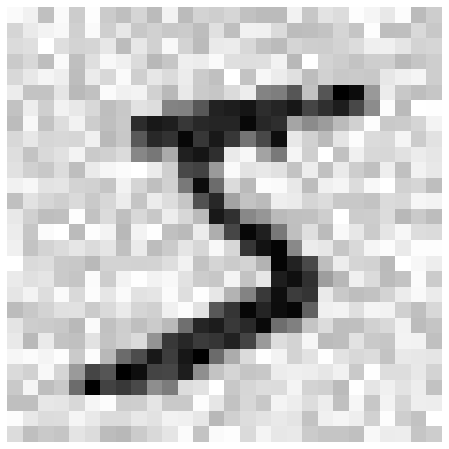

In [30]:
# lets look at the first noisy image
digit_num = 0
some_digit = X_train_noise[digit_num]
plot_digit(some_digit)



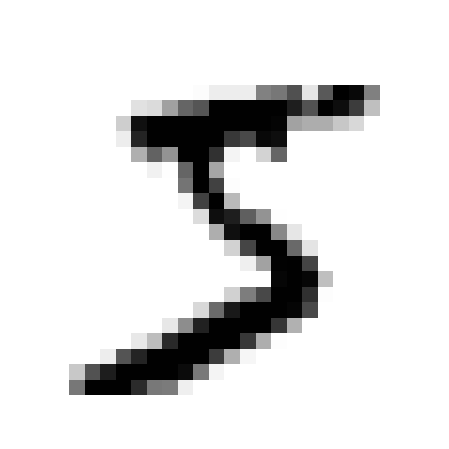

In [31]:
# and its original clean version
some_digit = y_train_noise[digit_num]
plot_digit(some_digit)

Now we will train the a knn classifier again on this multioutput multiclass task.

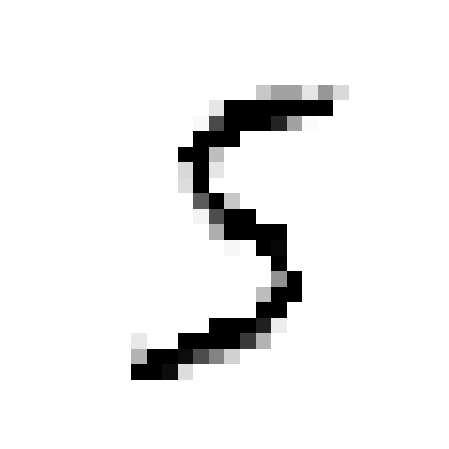

In [37]:
knn_clf.fit(X_train_noise, y_train_noise)

digit_num = 0
some_digit = X_train_noise[digit_num]
clean_digit = knn_clf.predict([some_digit]

plot_digit(clean_digit)

In [38]:
# display version information of library versions used in this notebook
from ml_python_class.custom_funcs import version_information
version_information()

              Module   Versions
--------------------   ------------------------------------------------------------
         matplotlib:   ['3.2.2']
              numpy:   ['1.18.5']
             pandas:   ['1.0.5']
            seaborn:   ['0.10.1']
